In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import matplotlib.ticker as ticker
import pandas as pd
import helmeos
from glob import glob
import subprocess
import os

In [2]:
gconst = 6.67430e-8
clight = 2.99792458e10
solar = 1.98847e33
lencgs2code = (clight**2)/(solar*gconst)
masscgs2code = (1.0e0/solar)
rhocgs2code = (masscgs2code/lencgs2code**3)
tcgs2code = (clight**3)/(solar*gconst)
energycgs2code = (1.0E0/clight**2)
avo = 6.0221367e23
amu = 1.6605402e-24
ev2erg = 1.60217648740e-12
mev2erg = ev2erg*1.0e6
mev2gr = mev2erg/clight**2

In [3]:
def filtering(array,atmo_indicies):
    dummy = np.copy(array)
    dummy[atmo_indicies] = 0
    return dummy

def helmeos_e(dens, temp, abar, zbar):
    out = helmeos.eos_DT(dens, temp, abar, zbar)
    return out['etot']

In [4]:
# set the number of nucleons in the element
aion = np.array([4,12,16,20,14,28,56])

# set the number of protons in the element
zion = np.array([2,6,8,10,12,14,28])

# set the binding energy of the element
bion = np.array([28.29603,92.16294,127.62093,160.64788,198.25790,236.53790,484.00300])

# ! set the number of neutrons and mass
nion = aion - zion


# mass of each isotope
mion = nion*1.67492721184e-24 + zion*1.67262163783e-24 - bion*mev2gr          

# a common approximation   
wion = aion       

def azbar(xmass):
    # molar abundances
    ymass = xmass/wion

    # mean molar mass
    wbar  = 1.0e0/np.sum(ymass)

    # mean number of nucleons
    sum1  = np.sum(aion*ymass)
    abar  = wbar * sum1

    # mean charge
    ye  = np.sum(zion*ymass)
    zbar  = wbar * ye

    return abar, zbar


In [5]:
working_directory = '/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/10.4km/'
profile_directory = '/home/cnchong/Codes/cumc3d/model/Type_Ia/profile/10.4km/'
SNEC_DIR = '/home/cnchong/Codes/SNEC-1.01/profiles'
files = []
for f in glob(working_directory+'/*.hdf5'):
    files.append(f)
n = len(files)-1

In [7]:
# Read file
filename = working_directory+"/rkiter-"+str(0)+"-nm.hdf5"
f0 = h5py.File(filename, "r")
f0.keys()
primitive = f0['primitive'][:].T
atmo = f0['prim_a(irho)'][0]
rho = primitive[0,1:-1,1,1:-1]
atmo_indicies = rho>atmo


# Face value
x1f = np.loadtxt(profile_directory+'/hydro_x1_fgrid.dat').T
x3f = np.loadtxt(profile_directory+'/hydro_x3_fgrid.dat').T
# Center value
x1f = x1f [3:-3]*lencgs2code # Remove BC
x1c = (x1f[1:]+x1f[:-1])/2 #mid pt
x3f = x3f[3:-3]*lencgs2code # Remove BC
x3c = (x3f[1:]+x3f[:-1])/2 #mid pt

xx,yy= np.meshgrid(x1c,x3c,indexing='ij')
rr_grid = np.sqrt(xx**2+yy**2)

xxf, yyf = np.meshgrid(x1f,x3f,indexing='ij')

# dx = np.diff(x1f)[0] # 2dx = dr
# dx2 = np.diff(xxf[:,0]**2)
# dy = np.diff(yyf[0,:])
# dxx2,dyy = np.meshgrid(dx2,dy,indexing='ij')
# vol = dxx2*dyy*np.pi

nr = 300
dr = (x1f[-1]-x1f[0])/nr
dx = dr/2 #r coordinates in the center
vol = (f0['vol'][:].T)[:,0,:]
r_arr = np.linspace(dx, x1f[-1]-dx, num=nr)

initial_mass = np.sum((rho*vol)[atmo_indicies])

In [8]:
ind = rho/rhocgs2code<1e5
rho[ind] = 1e5*rhocgs2code
np.sum(rho*vol)

1.4035029709677

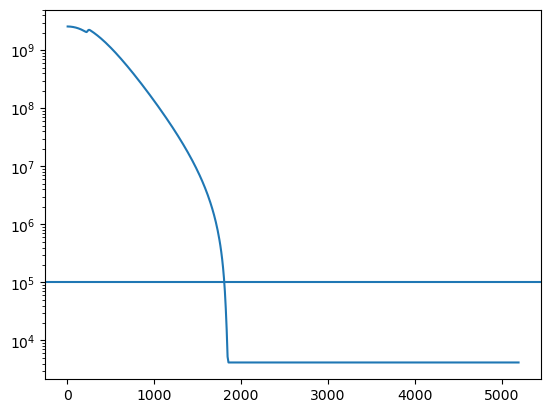

In [49]:
plt.plot(x1c/lencgs2code*1e-5, rho[:,500]/rhocgs2code)
plt.yscale('log')
plt.axhline(y=1e5)

In [39]:
initial_radius = x1c[np.argwhere(rho[:,500]/rhocgs2code<1e5)[0][0]]/lencgs2code*1e-5 # in km
initial_radius

1814.131778820989

In [7]:
print('Initial mass is', initial_mass, 'solar mass')

Initial mass is 1.3603971406139834 solar mass


In [8]:
mass_list = []
for i in range(n):
    filename = working_directory+"/rkiter-"+str(i)+"-nm.hdf5"
    f = h5py.File(filename, "r")
    primitive = f['primitive'][:].T
    atmo = f['prim_a(irho)'][0]
    rho = primitive[0,1:-1,1,1:-1]
    atmo_indicies = rho<=atmo
    filtered_rho = filtering(rho, atmo_indicies)
    mass_list.append(np.sum((filtered_rho*vol)[rr_grid<=(np.max(r_arr)+dx)]))
mass_arr = np.array(mass_list)
last = np.argwhere((mass_arr-initial_mass) < -1e-5)[0][0]

In [9]:
mass_arr-initial_mass

array([-2.22044605e-16, -2.93914317e-08, -3.82258689e-08, -6.34729711e-08,
       -1.35482466e-07, -2.00982755e-07, -2.61730560e-07, -3.19625982e-07,
       -3.86446479e-07, -4.70572097e-07, -5.61470874e-07, -5.59041149e-07,
       -5.72084625e-07, -5.78250971e-07, -6.08610048e-07, -6.36588573e-07,
       -5.68999421e-07, -5.44099804e-07, -4.61776104e-07, -3.58370961e-07,
       -2.47180055e-07,  1.28159506e-07,  6.53398258e-07,  1.17244411e-06,
        3.13039781e-06,  1.32567579e-05,  2.52310971e-05,  3.78823941e-05,
        5.07265317e-05,  6.40886590e-05,  7.75489076e-05,  9.10835074e-05,
        1.04781975e-04,  1.18609031e-04,  1.32558207e-04,  1.46507273e-04,
        1.60614970e-04,  1.74534378e-04,  1.88307204e-04,  2.02375061e-04,
        2.16174591e-04,  2.29842997e-04,  2.43656218e-04,  2.57295344e-04,
        2.70715987e-04,  2.84141177e-04,  2.97464879e-04,  3.10707776e-04,
        3.23516700e-04,  3.36272931e-04,  3.49220695e-04,  3.61860810e-04,
        3.74158236e-04,  

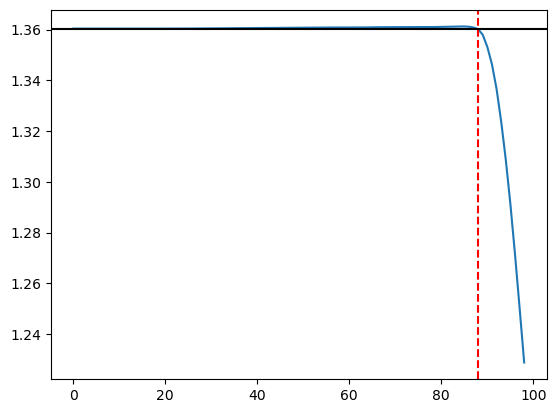

In [10]:
plt.plot(mass_arr)
plt.axvline(x=last, color='red',linestyle='--')
plt.axhline(y=initial_mass, color = 'black')

In [11]:
# Read file
filename = working_directory+"/rkiter-"+str(last)+"-nm.hdf5"
f = h5py.File(filename, "r")
f.keys()
print('Simulation time until mass is not conserved within 1D spherical grid is',str(f['time'][0]/tcgs2code),'seconds')

Simulation time until mass is not conserved within 1D spherical grid is 0.8965836006927789 seconds


In [12]:
primitive = f['primitive'][:].T
eps = (f['epsilon'][:].T)[1:-1,1,1:-1]
abar = (f['abar'][:].T)[1:-1,1,1:-1]
zbar = (f['zbar'][:].T)[1:-1,1,1:-1]
atmo = f['prim_a(irho)'][0]
temp = (f['temp'][:].T)[1:-1,1,1:-1]

rho = primitive[0,1:-1,1,1:-1]
atmo_indicies = rho<=atmo
v1 = primitive[1,1:-1,1,1:-1]
v2 = primitive[2,1:-1,1,1:-1]
v3 = primitive[3,1:-1,1,1:-1]
Ye = primitive[13,1:-1,1,1:-1]

Den_he = primitive[6,1:-1,1,1:-1]*rho
Den_c = primitive[7,1:-1,1,1:-1]*rho
Den_o = primitive[8,1:-1,1,1:-1]*rho
Den_ne = primitive[9,1:-1,1,1:-1]*rho
Den_mg = primitive[10,1:-1,1,1:-1]*rho
Den_si = primitive[11,1:-1,1,1:-1]*rho
Den_ni = primitive[12,1:-1,1,1:-1]*rho

#Number density of nucleons / baryon and electron
Num_he = primitive[6,1:-1,1,1:-1]*rho/rhocgs2code/mion[0]*avo*zion[0]
Num_c = primitive[7,1:-1,1,1:-1]*rho/rhocgs2code/mion[1]*avo*zion[1]
Num_o = primitive[8,1:-1,1,1:-1]*rho/rhocgs2code/mion[2]*avo*zion[2]
Num_ne = primitive[9,1:-1,1,1:-1]*rho/rhocgs2code/mion[3]*avo*zion[3]
Num_mg = primitive[10,1:-1,1,1:-1]*rho/rhocgs2code/mion[4]*avo*zion[4]
Num_si = primitive[11,1:-1,1,1:-1]*rho/rhocgs2code/mion[5]*avo*zion[5]
Num_ni = primitive[12,1:-1,1,1:-1]*rho/rhocgs2code/mion[6]*avo*zion[6]
Num_n = Num_he + Num_c + Num_o + Num_ne + Num_mg + Num_si + Num_ni
Num_e = Num_n * (np.minimum(Ye*abar, zbar)/abar)


In [13]:
masshell_r = []
mass_r = []
ke_r = []
dens_r = []
vel_r = []
inte_r = []
abar_r = []
zbar_r = []
Ye_r = []
Tguess_r = []
xiso_r = []
r_vol_r = []

for r in r_arr:
    filtered_rho = filtering(rho, atmo_indicies)
    r_indicies = np.logical_and(r-dx<=rr_grid, rr_grid<r+dx)
    inner_r_indicies = (rr_grid <= (r-dx))
    r_vol = 4*np.pi*((r+dr)**3-(r-dr)**3)/3

    mass = np.sum((filtered_rho*vol)[r_indicies])
    mass_coord = np.sum((filtered_rho*vol)[inner_r_indicies])
    ke = 0.5 * np.sum( (filtered_rho*vol*(v1**2+v3**2) )[r_indicies] )
    inte = np.sum((filtered_rho*vol*eps )[r_indicies] )/mass #energy per mass in this shell
    dens = mass/r_vol

    # Xiso
    filtered = filtering(Den_he, atmo_indicies)
    xiso_he = np.sum((filtered*vol)[r_indicies])/r_vol/dens

    filtered = filtering(Den_c, atmo_indicies)
    xiso_c = np.sum((filtered*vol)[r_indicies])/r_vol/dens
    
    filtered = filtering(Den_o, atmo_indicies)
    xiso_o = np.sum((filtered*vol)[r_indicies])/r_vol/dens

    filtered = filtering(Den_ne, atmo_indicies)
    xiso_ne = np.sum((filtered*vol)[r_indicies])/r_vol/dens

    filtered = filtering(Den_mg, atmo_indicies)
    xiso_mg = np.sum((filtered*vol)[r_indicies])/r_vol/dens

    filtered = filtering(Den_si, atmo_indicies)
    xiso_si = np.sum((filtered*vol)[r_indicies])/r_vol/dens

    filtered = filtering(Den_ni, atmo_indicies)
    xiso_ni = np.sum((filtered*vol)[r_indicies])/r_vol/dens

    xiso = np.array([xiso_he, xiso_c, xiso_o, xiso_ne, xiso_mg, xiso_si, xiso_ni])

    # Ye
    filtered = filtering(Num_e, atmo_indicies)
    Ne_r = np.sum((filtered*vol)[r_indicies])

    filtered = filtering(Num_n, atmo_indicies)
    Ne_n = np.sum((filtered*vol)[r_indicies])

    Ye = Ne_r/Ne_n

    # Abar and Zbar

    abar, zbar = azbar(xiso)

    zbar = np.minimum(zbar, Ye*abar)

    # Guess Temperature

    min_index =  np.argmin(np.abs((filtered_rho-dens)[r_indicies]))


    masshell_r.append(mass/masscgs2code)
    mass_r.append(mass_coord/masscgs2code)
    dens_r.append(dens/rhocgs2code)
    vel_r.append(np.sqrt(2*ke/mass)*clight)
    ke_r.append(ke/masscgs2code*clight**2)
    inte_r.append(inte/energycgs2code)
    abar_r.append(abar)
    zbar_r.append(zbar)
    Ye_r.append(Ye)
    xiso_r.append(xiso)
    Tguess_r.append(temp[r_indicies][min_index]*1e9)
    r_vol_r.append(r_vol)

masshell_r = np.array(masshell_r)
mass_r = np.array(mass_r)
ke_r = np.array(ke_r)
dens_r = np.array(dens_r)
vel_r = np.array(vel_r)
inte_r = np.array(inte_r)
abar_r = np.array(abar_r)
zbar_r = np.array(zbar_r)
Ye_r = np.array(Ye_r)
Tguess_r = np.array(Tguess_r)
xiso_r = np.array(xiso_r).T
r_vol_r = np.array(r_vol_r)

all = np.array((inte_r,dens_r,abar_r,zbar_r,Ye_r,Tguess_r))


In [14]:
output_n = np.zeros(1, dtype='int')
output_n[0] = len(r_arr)
np.savetxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/Inter_SNEC.dat', output_n, fmt='%i')
f = open('/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/Inter_SNEC.dat', 'a')
np.savetxt(f, all)
f.close()

In [15]:
subprocess.run('/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/Invert_Helm.out')

CompletedProcess(args='/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/Invert_Helm.out', returncode=0)

In [16]:
T_r = np.loadtxt('/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/Python_SNEC.dat')
# default = helmeos.HelmTable()
# Tbyhelm = default.eos_invert(dens_r,abar_r,abar_r, inte_r,'etot')

Initializing Helmholtz EOS table /home/cnchong/miniconda3/envs/Rotating_WD/lib/python3.12/site-packages/helmeos/helm_table.dat


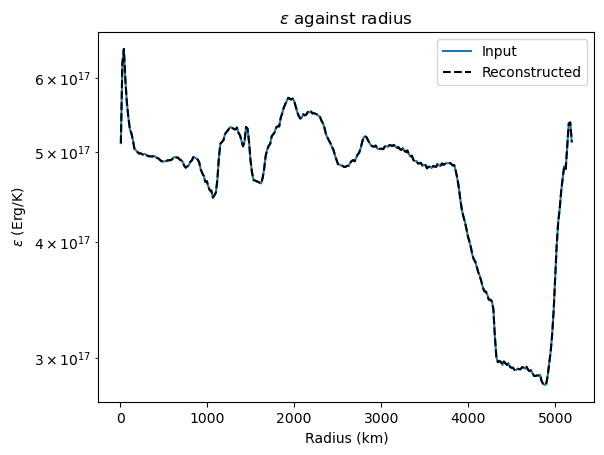

In [17]:
plt.plot(r_arr/lencgs2code/100000, inte_r, label='Input')
plt.plot(r_arr/lencgs2code/100000,helmeos_e(dens_r,T_r,abar_r,zbar_r), color='black', linestyle='dashed',label='Reconstructed')
plt.yscale('log')
plt.ylabel(r'$\epsilon$ (Erg/K)')
plt.xlabel('Radius (km)')
plt.title(r'$\epsilon$ against radius')
plt.legend()

In [18]:
file_name = 'MHD_TypeIa'
indicies = np.arange(output_n)+1
omega = np.zeros(output_n)
SNEC_arr = np.array((indicies, mass_r, r_arr/lencgs2code, T_r, dens_r, vel_r, Ye_r, omega))
fmt_arr = ['%i', '%1.18e', '%1.18e', '%1.18e', '%1.18e', '%1.18e', '%1.18e', '%1.18e']
np.savetxt(working_directory+'/'+file_name+'.short', output_n, fmt='%i')
np.savetxt(SNEC_DIR+'/'+file_name+'.short', output_n, fmt='%i')
f = open(working_directory+'/'+file_name+'.short', 'a')
g = open(SNEC_DIR+'/'+file_name+'.short', 'a')
np.savetxt(f, SNEC_arr.T,fmt=fmt_arr, delimiter='     ')
np.savetxt(g, SNEC_arr.T,fmt=fmt_arr, delimiter='     ')
f.close()
g.close()
os.remove('/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/Inter_SNEC.dat')
os.remove('/home/cnchong/Codes/cumc3d/model/Type_Ia/outfile/Python_SNEC.dat')

/tmp/ipykernel_295123/2022223603.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  indicies = np.arange(output_n)+1


In [19]:
f = open(working_directory+'/'+file_name+'.iso.dat', 'w')
g = open(SNEC_DIR+'/'+file_name+'.iso.dat', 'w')
comp_profile_n = np.array((output_n[0], 7))

for i in comp_profile_n:
    f.write(str(i)+'     ')
    g.write(str(i)+'     ')
f.write("\n")
g.write("\n")

for i in aion:
    f.write(str(i)+'     ')
    g.write(str(i)+'     ')
f.write("\n")
g.write("\n")

for i in zion:
    f.write(str(i)+'     ')
    g.write(str(i)+'     ')
f.write("\n")
g.write("\n")

SNEC_profile_arr = np.array((mass_r, r_arr/lencgs2code, xiso_r[0],xiso_r[1],xiso_r[2],xiso_r[3],xiso_r[4],xiso_r[5],xiso_r[6]))
np.savetxt(f, SNEC_profile_arr.T, delimiter='     ')
np.savetxt(g, SNEC_profile_arr.T, delimiter='     ')
f.close()
g.close()

In [20]:
sum = 0
for i in range(7):
    sum += np.sum((xiso_r[6,:]*dens_r*rhocgs2code*r_vol_r))

In [21]:
print('Mass of He is',np.sum((xiso_r[0,:]*dens_r*rhocgs2code*r_vol_r)), 'solar mass')

Mass of He is 0.026268688205143723 solar mass


In [22]:
print('Mass of Ni is',np.sum((xiso_r[6,:]*dens_r*rhocgs2code*r_vol_r)), 'solar mass')
print('Mass coordinate of boundary Ni is', mass_r[-1]*masscgs2code, 'solar mass')

Mass of Ni is 0.7686419718481783 solar mass
Mass coordinate of boundary Ni is 1.3600724768859356 solar mass


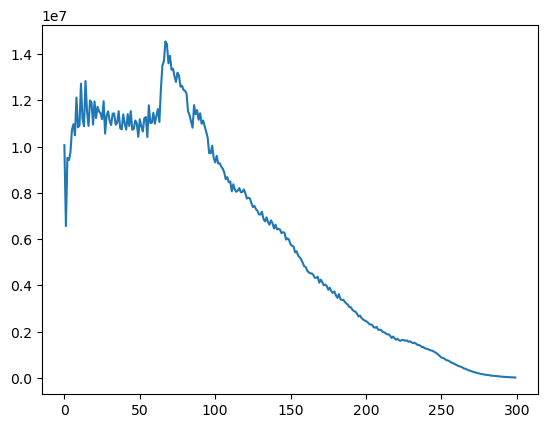

In [23]:
plt.plot(dens_r)